# Module 3 Final Project

Student name: Isabella Lindgren <br/>
Student pace: Part Time <br/>
Scheduled project review date/time: 10/22/2019 8:00pm EST<br/>
Instructor name: Eli Thomas

## The Scientific Method

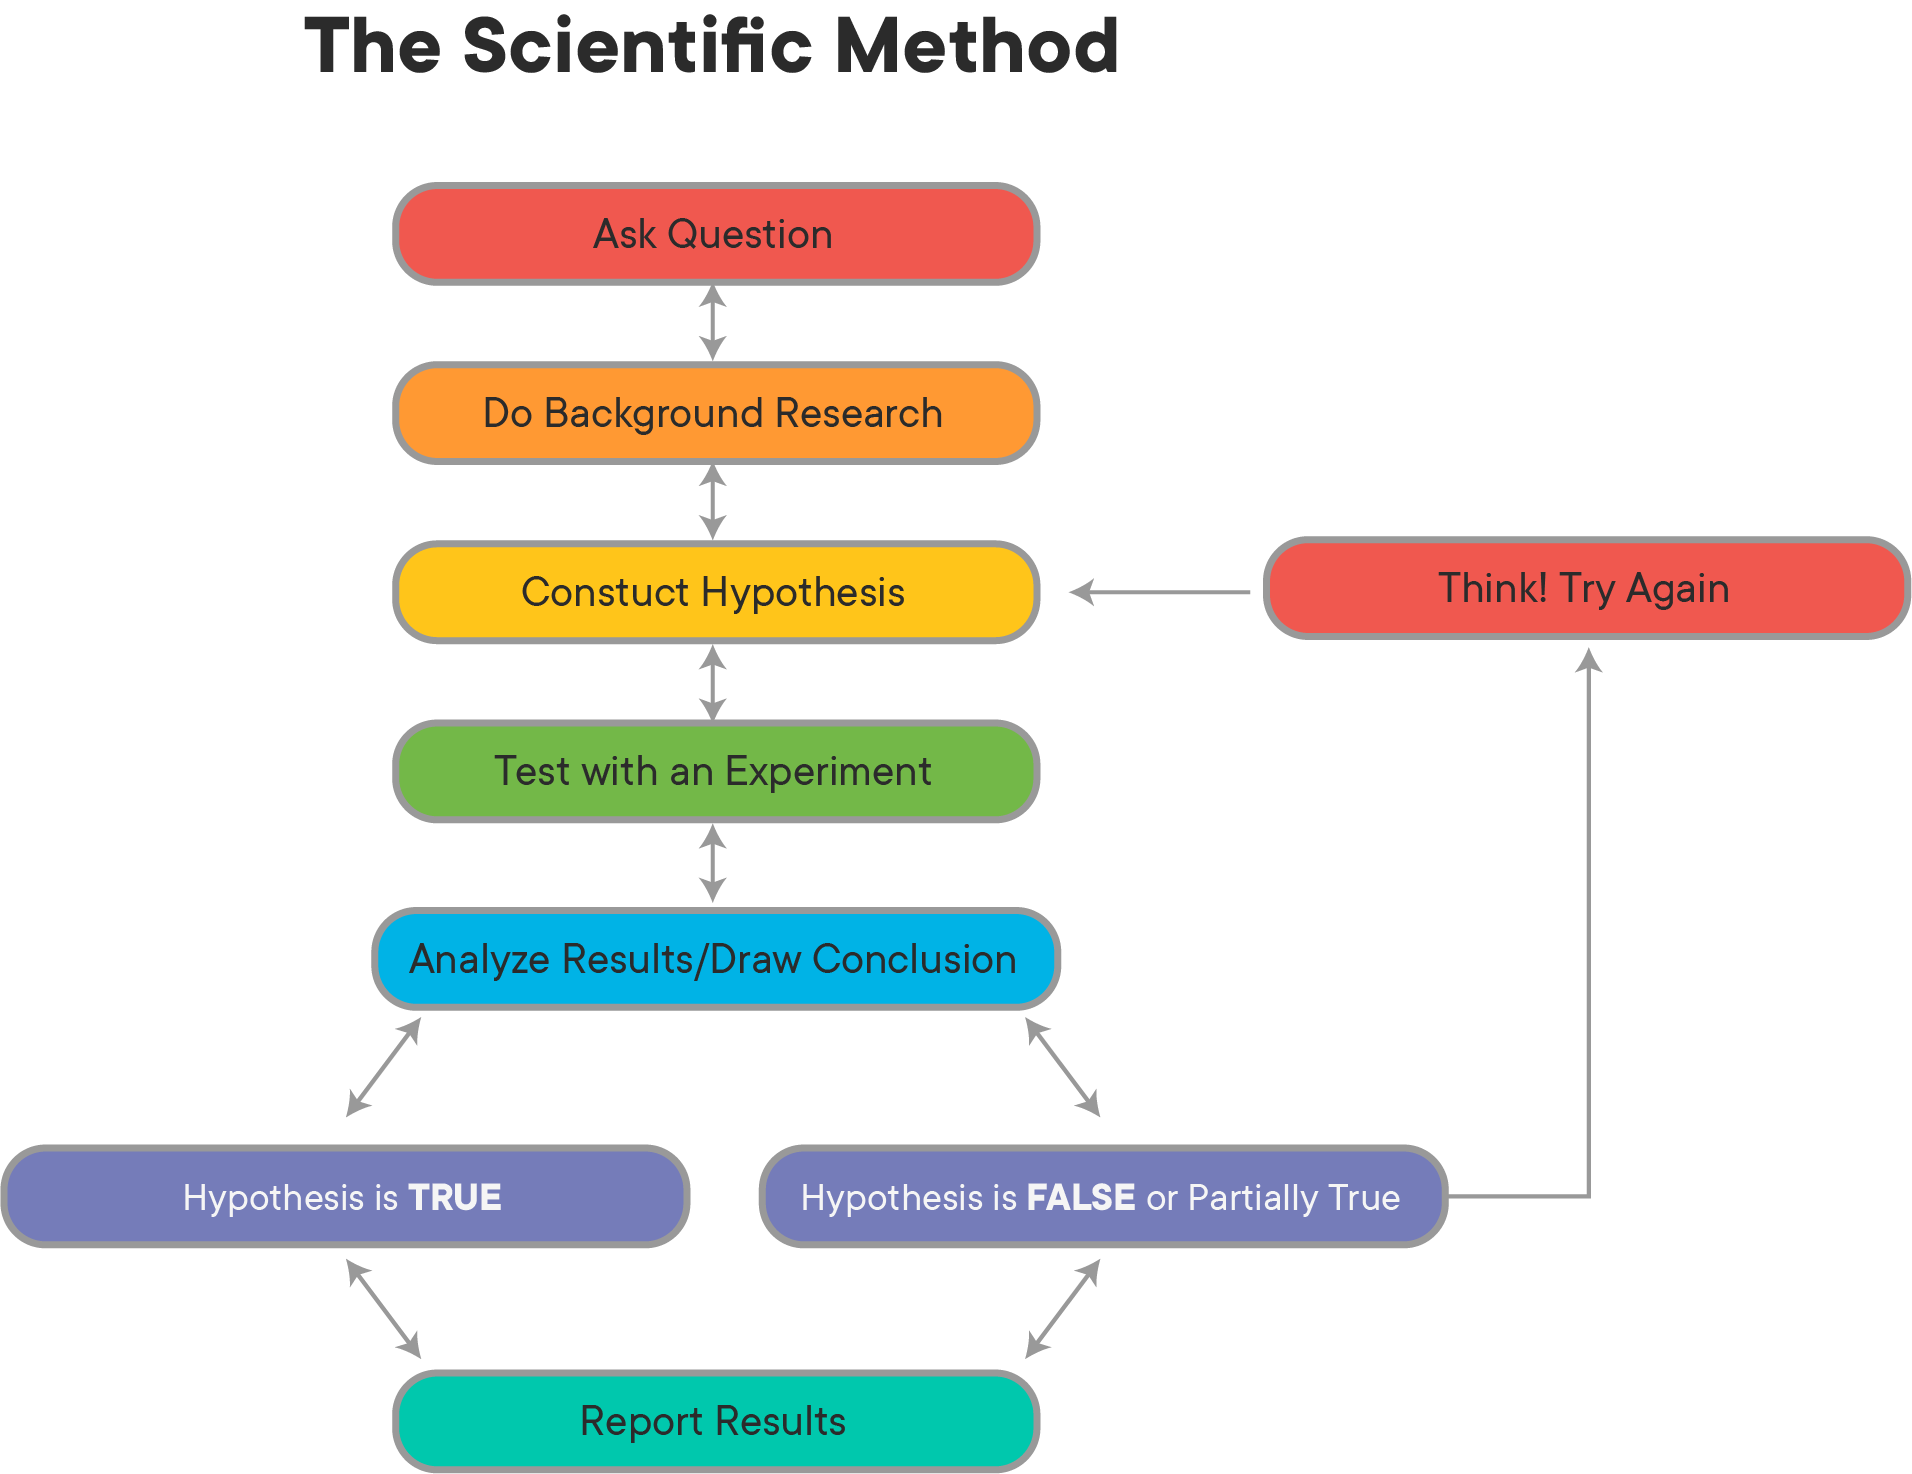

The scientific method is the process for creating and carrying out an experiment to obtain observations and answer questions. In this module, we will be demonstrating each step of the scientific method to answer questions regarding the Northwind Traders Database.

## Northwind Traders Database <br/>
Northwind Traders is a sample database for a fictitious specialty food trading company. It contains all sales transactions that occur between the company Northwind Traders and its customers as well as the purchase transactions between Northwind Traders and its suppliers.

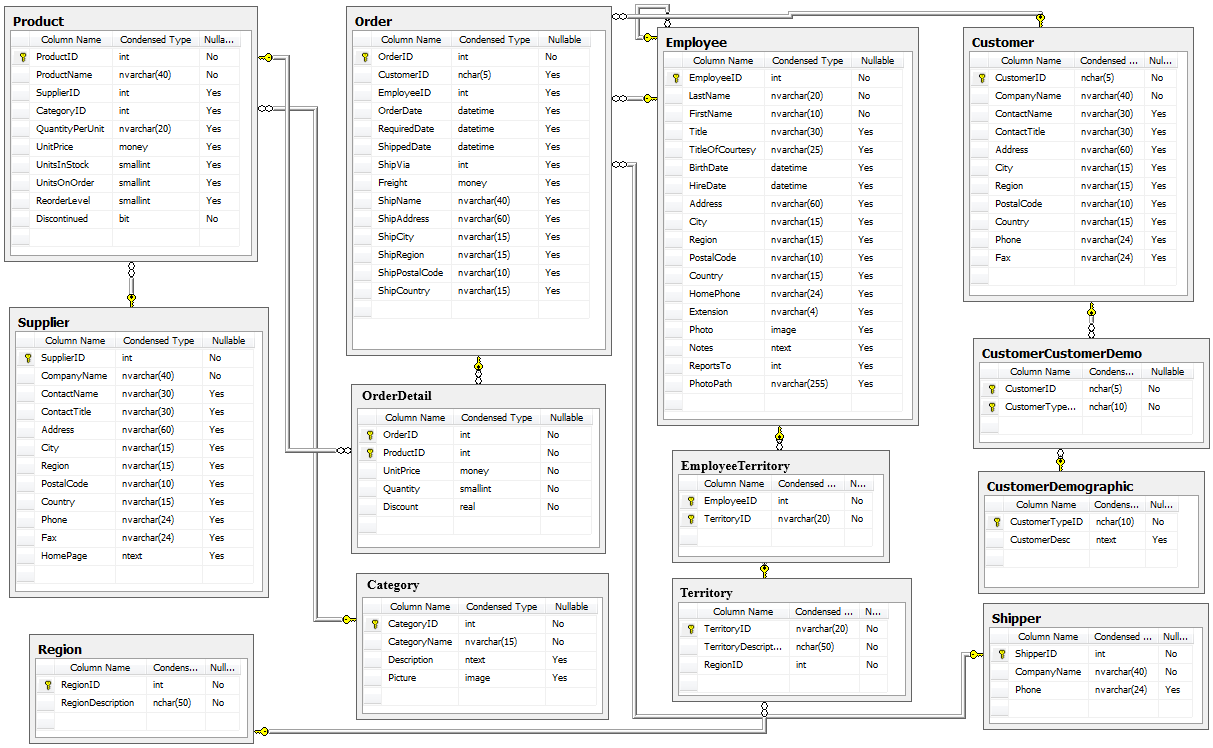

### Background information:
1.	Supplier - Vendors of Northwind – who supplies products to Northwind.
2.  Product - the products that Northwind trades in, inventory details
3.  Category - The category ID and category name of the products and their descriptions
4.  OrderDetail - invoice for the orders placed by customers of Northwind. Details of what is in the order
5.  Order - the details of the order itself - who placed it, the employee, shipping dates, freight costs etc
6.  Employee details of Northwind traders – who works for Northwind and their information
7.  Customers of Northwind – who buys products from Northwind.
8.  Employee Territory - employee id and territory id
9.  Territory - territory ID, region and description
10.  Region - RegionID and description
11.  Shipper - details of the shippers who ship the products from the traders to the end-customers

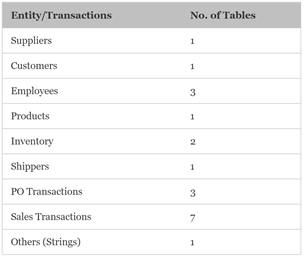
Source: https://theaccessbuddy.wordpress.com/2011/07/03/northwind-database-explained/

It is important to take into account how each of these tables are linked in order to answer complex questions from a variety of perspectives. We will explore these relationships in our Exploratory Data Analysis when investigating four main parts of Northwind: 
<br/>
>**1) Discounts** <br/>
**2) Employees** <br/>
**3) Customers** <br/>
**4) Freight** <br/>

# Objectives:

The purpose of this project is to query data from the Northwind Traders database and use statistical analysis and hypothesis testing to generate analytical insights into the following questions:

>**1. Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?** <br/><br/>
**2. Is there a statistically significant difference between the revenue US employees bring in compared to UK employees?**<br/><br/>
**3. Do people who order more frequently than average also generate more sales?**<br/><br/>
**4. Is there a significant difference in the freight costs per region?**

First, import all the necessary libraries.

In [403]:
import sqlite3 as sql
import pandas as pd 
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 
sns.set_style("darkgrid")
import numpy as np 
import scipy.stats as scs
import itertools 
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


import warnings
warnings.filterwarnings('ignore') # hide matplotlib warnings

Then, we connect to the Northwind Traders database to grab all the information.

In [405]:
conn = sql.connect('Northwind_small.sqlite') # connect to database
c = conn.cursor() # create cursor

table_names = c.execute('''SELECT name FROM sqlite_master WHERE TYPE = 'table';''').fetchall()
table_names = [i[0] for i in table_names] 
table_names

['Employee',
 'Category',
 'Customer',
 'Shipper',
 'Supplier',
 'Order',
 'Product',
 'OrderDetail',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Region',
 'Territory',
 'EmployeeTerritory']

Next, we convert all the tables into dataframes which are easier to manipulate and analyze.

In [406]:
dfs = []
for i in table_names:
    # select all data for each column
    table = c.execute('SELECT * FROM "'+i+'"').fetchall()         
    columns = c.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    # change string into a variable name
    x = i+"_df"
    exec(x + " = df")
    # add new df names to list 'dfs'
    dfs.append(x)

dfs  # double check and make sure all tables have now been turned into dataframes

['Employee_df',
 'Category_df',
 'Customer_df',
 'Shipper_df',
 'Supplier_df',
 'Order_df',
 'Product_df',
 'OrderDetail_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Region_df',
 'Territory_df',
 'EmployeeTerritory_df']

### Sales over Time 
<br/>
Let's briefly get an idea of Northwind's business to see how it has performed over time.

In [412]:
sales_over_time = pd.read_sql_query('''SELECT o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.OrderDate
                            ;''', conn)

In [413]:
sales_over_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
OrderDate      480 non-null object
TotalAmount    480 non-null float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


In [414]:
sales_over_time['OrderDate'] = pd.to_datetime(sales_over_time['OrderDate'])


In [415]:
sales_over_time['mnth_yr'] = sales_over_time['OrderDate'].apply(lambda x: x.strftime('%B-%Y'))

In [416]:
sales_over_time.head()

,OrderDate,TotalAmount,mnth_yr
0,2012-07-04,440.00,July-2012
1,2012-07-05,1863.40,July-2012
2,2012-07-08,2206.66,July-2012
3,2012-07-09,3597.90,July-2012
4,2012-07-10,1444.80,July-2012


In [417]:
x = sales_over_time['mnth_yr']
y = sales_over_time['TotalAmount']

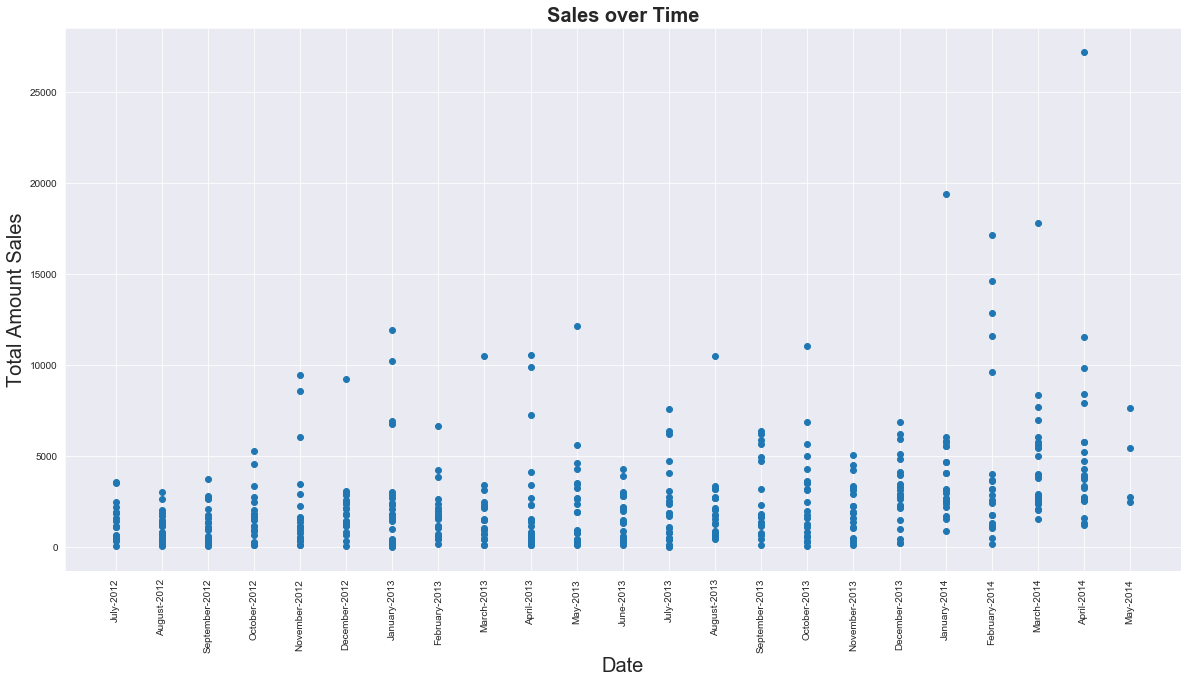

In [418]:
plt.figure(figsize=(20,10)) 
plt.scatter(x, y);
plt.title('Sales over Time', fontsize=20, fontweight='bold')

plt.xlabel('Date',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('Total Amount Sales', fontsize=20);


# We can see the amount of revenue increasing over time

We can see that the total amount of sales increases from July 2012 to May 2014. So how can we improve the **profitability** of Northwind?

# Question 1:
## *Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?*

In order to answer this first question, we should break it down into two hypotheses: the null hypothesis (H<sub>0</sub>) and the alternative hypothesis (H<sub>1</sub>). The null hypothesis is when there is no significant difference between specified populations. The alternate hypothesis is the opposite of the null hypothesis and it is the focus of our testing.

## Part 1:

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the quantity of product in orders with a discount compared to orders without a discount.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub>The discount amount has an effect on the quantity of product in an order.

We will be using a two-tailed test to answer this question because if we do reject the null hypothesis, we can determine if the discount amount has a positive or negative effect on the quantity of a product in an order.
<br/>
<br/>
To test our hypotheses, we will need the 'Quantity' and 'Discount' columns in our 'OrderDetail_df' table. 

### Exploring our data:


### Quantity of Discounted Products vs Non-Discounted Products

In [419]:
# Let's get an overview of the Order Detail dataframe
OrderDetail_df.head() 

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


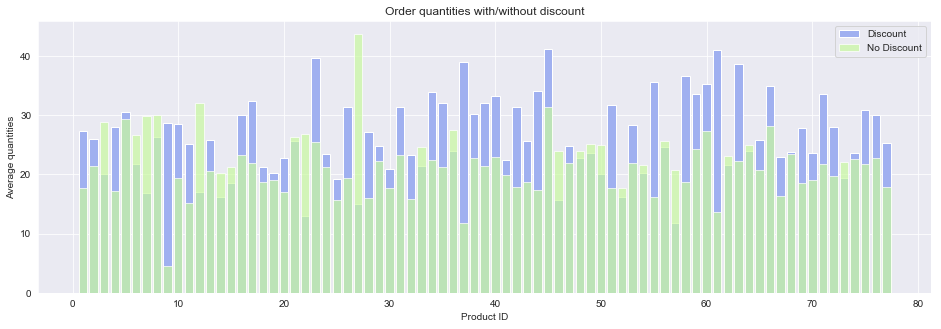

Conclusion
On average 70.0% of discounted products were sold in larger quantities
Average order quantity with discount - 26.43 items, without - 21.81 items


In [420]:
# Great visualization plot comparing order quantities with discounts and without discounts by Product ID
# provided by Arseniyturin source: https://github.com/arseniyturin/dsc-2-final-project-online-ds-sp-000/blob/master/Project%202%20Student.ipynb

discount = OrderDetail_df[OrderDetail_df['Discount']!=0].groupby('ProductId')['Quantity'].mean()
no_discount = OrderDetail_df[OrderDetail_df['Discount']==0].groupby('ProductId')['Quantity'].mean()
plt.figure(figsize=(16,5))

plt.bar(discount.index, discount.values, alpha=1, label='Discount', color='#a0b0f0')
plt.bar(no_discount.index, no_discount.values, alpha=0.7, label='No Discount', color='#c9f9a0')
plt.legend()
plt.title('Order quantities with/without discount')
plt.xlabel('Product ID')
plt.ylabel('Average quantities')
plt.show()

print('Conclusion')
print("On average {}% of discounted products were sold in larger quantities".format(round(sum(discount.values > no_discount.values)/len(discount.values)*100),2))
print("Average order quantity with discount - {} items, without - {} items".format(round(discount.values.mean(),2), round(no_discount.values.mean(),2)))

In [421]:
data1 = OrderDetail_df[['Quantity', 'Discount','UnitPrice']]
data1.info() # see the number of values and data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 3 columns):
Quantity     2155 non-null int64
Discount     2155 non-null float64
UnitPrice    2155 non-null float64
dtypes: float64(2), int64(1)
memory usage: 50.6 KB


We can see that there are no missing values in any of the columns. Now we'll use .describe() to look at basic stats.

In [422]:
data1.describe()

,Quantity,Discount,UnitPrice
count,2155.000000,2155.000000,2155.000000
mean,23.812993,0.056167,26.218520
std,19.022047,0.083450,29.827418
min,1.000000,0.000000,2.000000
25%,10.000000,0.000000,12.000000
50%,20.000000,0.000000,18.400000
75%,30.000000,0.100000,32.000000
max,130.000000,0.250000,263.500000


The mean amount of items purchased per order is approximately 24 items, with orders ranging from 1 product to 130 products. The mean discount is 0.056 with a range from 0 to .25. The mean UnitPrice of a product is about 26 dollars with a range from $2.00 - 263.50.

In [423]:
# Function for plotting histograms
def sns_histogram(values, bins=20, alpha=0.5):
    plt.figure(figsize=(8, 5))
    plt.grid(True)
    sns.distplot(values, bins=bins)
    plt.show()

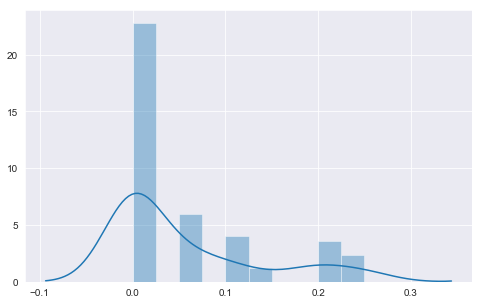

In [424]:
sns_histogram(np.random.choice(OrderDetail_df.Discount, size = 100), bins = 10)

In [425]:
# Let's find the different levels of discounts there are
OrderDetail_df['Discount'].value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

1317 products have no discount and the other products have discounts of 1%, 2%, 3%, 4%, 5%, 6%, 10%, 15%, 20%, or 25%. Since we are comparing discounted and non-discounted products, we will separate these categories into two separate categories: 'discount' and 'no_discount'

In [426]:
no_discount = OrderDetail_df[OrderDetail_df['Discount'] == 0].copy()
discount = OrderDetail_df[OrderDetail_df['Discount'] != 0].copy()

### Assumptions

In order to determine which statistical test is appropriate for this experiment, we must check three different assumptions: <br/>
 - Normality - the data has a normal (or at least symmetric) distribution
 - Homogeneity of variances - data from both groups have the same variance
 - Independence - the data is independent of each other

We will use the **Shapiro-Wilk test** to check for normality of the distribution. For this test, the hypotheses are:
- H0: distribution is normal
- H1: distribution is not normal

In [427]:
print(scs.shapiro(no_discount.Quantity))
print(scs.shapiro(discount.Quantity))

(0.8434571027755737, 3.803856556577728e-34)
(0.8690301179885864, 6.88120409395894e-26)


In [428]:
# Let's also try the  D’Agostino’s K^2 test to see if it differs from Shapiro-Wilk
# The D’Agostino’s K^2 test calculates summary statistics from the data, namely kurtosis and skewness, 
# to determine if the data distribution departs from the normal distribution

import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(no_discount.Quantity))
print('Normality of distribution: ', stat.normaltest(discount.Quantity))

Normality of distribution:  NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of distribution:  NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


The p-value is extremely small for both the shapiro and D-Agostino tests so we reject the null hypothesis that this data was taken from a normal distribution. Next, we'll check the homogeneity of variances using the **Levene Test**. Fot the Levene test, the hypotheses are:
- H0: The variances are equal
- H1: The variances are not equal

In [264]:
print(scs.levene(no_discount.Quantity, discount.Quantity))

LeveneResult(statistic=14.832671704073421, pvalue=0.00012091378376079568)


The low p-value indicates that the variances between the two samples are unequal. Since the distribution is not normal and the variances are different, we should not use a student's t-test since it will be inaccurate. Instead we will use Welch's T-test which takes into account unequal variance. 

**Independence and Randomness:**<br/>
The data is independent within groups and between groups because the items ordered by each shopper are different and have no influence on other shoppers. Each sample will be randomly chosen using the numpy random.choice function.

## Welch's T-test

The purpose of this test is similar to the student's t-test in that it determines if two sample means are significantly different, but unlike the student t-tests, Welch’s increases the test power for samples with unequal variance by adjusting the degrees of freedom. Welch’s tends to perform better than the standard t-test when the sample sizes and variances are unequal between groups and gives the same result as the standard t-test when the sample sizes and variances are equal.

In [429]:
# Create one random sample from each group
sample_no_discount=np.random.choice(no_discount.Quantity, size=100)
sample_discount=np.random.choice(discount.Quantity, size=100)

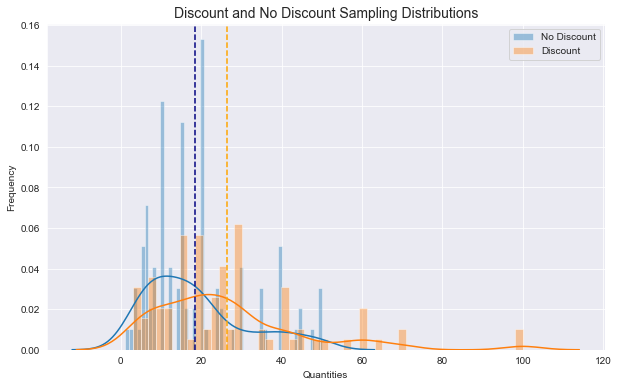

In [430]:
# Visualization of the distributions of each sample group and their respective means
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.distplot(sample_no_discount, bins=50, label = 'No Discount')
sns.distplot(sample_discount, bins=50, label = 'Discount')

plt.axvline(x=sample_no_discount.mean(), color='navy', linestyle = '--')
plt.axvline(x=sample_discount.mean(), color='orange', linestyle = '--')

plt.title('Discount and No Discount Sampling Distributions', fontsize = 14)
plt.xlabel('Quantities')
plt.ylabel('Frequency')

plt.legend()
plt.show();

In [431]:
# Welch's T-test
p = stats.ttest_ind(no_discount.Quantity, discount.Quantity)[1]
print("p-value: ", p)
print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')

p-value:  1.1440924523215966e-10
Reject Null Hypothesis


The p-value is extremely low so we reject the null hypothesis that there is no difference in the quantity of product in orders with a discount compared to orders without a discount. 
<br/>
<br/>
Since we determined that there is a significant difference between discount and non-discounted groups, let's do a multiwise comparison to determine which levels of discount are significant compared to the non-discounted products. The Tukey Multiwise comparison method controls for Type I errors and allows us to see pairwise comparisons of each discount level.

## Tukey Multiwise Comparison

In [445]:
mc1 = MultiComparison(OrderDetail_df['Quantity'], OrderDetail_df['Discount'])
mc1_results = mc1.tukeyhsd()
print(mc1_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

We reject the null hypothesis at 5%, 15%, 20% and 25% discount. This means that when there is a 5%, 15%, 20% or 25% discount, there is a statistically significant effect on the quantity of product ordered. 

Now, we will determine the size of the difference between the quantities within the discount and non-discount groups using Cohen's d statistic. The effect size is the difference between the sample means. 

## Cohen's D Statistic for Effect Size

We will be using Cohen's d statistic to calculate a *standardized* effect size by dividing the effect size by the standard deviations. The effect size represents the magnitude of differences between two (or more) groups. The larger the difference, the greater the effect size. <br/>

The basic formula to calculate Cohen’s $d$ is:

> **$d$ = effect size (difference of means) / pooled standard deviation**
<br/>

As a general rule of thumb, Cohen's D can be interpreted as: <br/>
- d=0.2 be considered a 'small' effect size

- d=0.5 represents a 'medium' effect size

- d=0.8 a 'large' effect size.

In [446]:
# define Cohen's d function that we will use throughout this project
def Cohen_d(group1, group2):

    diff = group1.mean() - group2.mean()
    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()
    
    # Calculate the pooled threshold 
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    return abs(d)

In [447]:
d = Cohen_d(no_discount.Quantity, discount.Quantity)
print("Cohen's d: ", d)

Cohen's d:  0.2862724481729283


A d statistic of 0.2 is generally considered to mean a small effect and a d statistic of 0.5 is generally considered to mean a medium effect. Since our d statistic is approx 0.287 we can consider the effect of discount on quantity to be on the smaller size. 

Now, we will approach the second half of the question - **At what discount level is the effect on quantity significant?** For this, we must look at the various discount amounts and determine at what amounts of discount affect quantity ordered the most.

## Part 2:

In [448]:
# Let's get an overview of how many discount levels there are and the value counts
data1_pt2 = data1[data1['Discount'] != 0]
print(data1_pt2['Discount'].value_counts())

0.05    185
0.10    173
0.20    161
0.15    157
0.25    154
0.03      3
0.02      2
0.04      1
0.06      1
0.01      1
Name: Discount, dtype: int64


Since the following discount levels (0.01, 0.02, 0.03, 0.04, 0.06) are so small compared to the other discount levels, let's bin them into 0.05 so we have 5 bins with similar counts. 

In [449]:
# lambda function to bin all discount levels less than 0.1 as '0.05'
data1_pt2['Discount'] = data1['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
data1_pt2['Discount'].value_counts() # Much Better!!

0.05    193
0.10    173
0.20    161
0.15    157
0.25    154
Name: Discount, dtype: int64

For the second part of this question, we will form another null and alternative hypothesis!
 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the quantity of product for each discount level.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub>There is a difference in the quantity of product ordered at different discount levels.

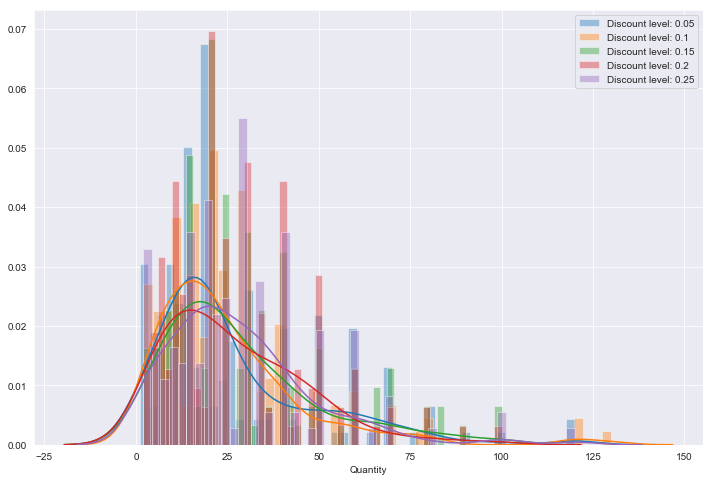

In [450]:
# Let's plot the distributions of each discount level 
plt.figure(figsize=(12, 8))
for i in sorted(data1_pt2.Discount.unique()):
    sns.distplot(data1_pt2.loc[data1_pt2.Discount==i]['Quantity'], label = 'Discount level: '+str(i), bins=50)
plt.legend()
plt.show()

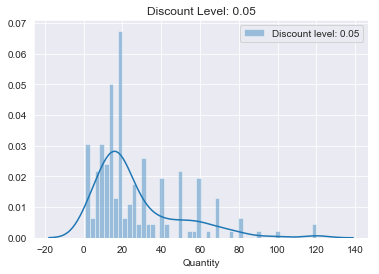

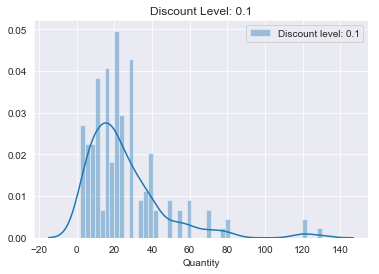

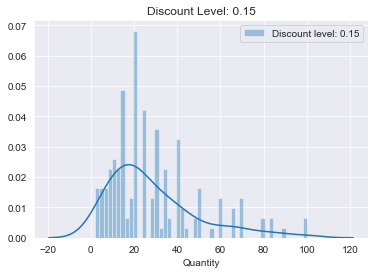

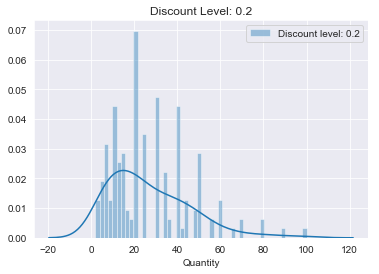

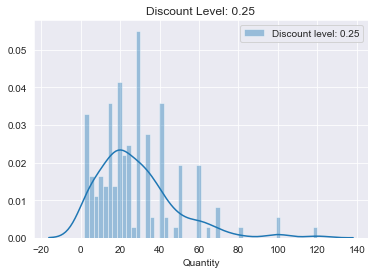

In [451]:
# Let's plot the distributions of each discount level individually

for i in sorted(data1_pt2.Discount.unique()):
    sns.distplot(data1_pt2.loc[data1_pt2.Discount==i]['Quantity'], label = 'Discount level: '+str(i), bins=50)
    plt.title(f'Discount Level: {str(i)}');
    plt.legend()
    plt.show()

We will use a one-way analysis of variance or ANOVA since we are considering only one independent variable, which is discount level. ANOVA allows us to analyze and compare the effectiveness of the individual feature change and is useful for testing multiple factors simultaneously.

## One Way ANOVA

In [441]:
formula = 'Quantity ~ C(Discount)'  # for a linear model and generate table
lm = ols(formula, data1_pt2).fit()
table = sm.stats.anova_lm(lm, typ=1) # for one way analysis
print(table)
lm.summary()

                df         sum_sq     mean_sq         F    PR(>F)
C(Discount)    4.0    1065.701253  266.425313  0.616376  0.650947
Residual     833.0  360060.198508  432.245136       NaN       NaN


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Quantity   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6164
Date:                Sun, 20 Oct 2019   Prob (F-statistic):              0.651
Time:                        20:01:06   Log-Likelihood:                -3729.5
No. Observations:                 838   AIC:                             7469.
Df Residuals:                     833   BIC:                             7493.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              26.9223      1.497     17.990      0.000      23.985      29.860
C(Discount)[T.0.1]     -1.6853      2.177     -0.774      0.439      -5.958       2.587
C(Discount)[T.0.15]     1.4599      2.234      0.653      0.514      -2.926       5.846
C(Discount)[T.0.2]      0.1026      2.219      0.046      0.963      -4.253       4.458
C(Discount)[T.0.25]     1.3180      2.246      0.587      0.558      -3.091       5.727
==============================================================================
Omnibus:                      265.156   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              753.997
Skew:                           1.593   Prob(JB):                    1.87e-164
Kurtosis:                       6.383   Cond. No.                         5.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see from our table that the p-value of our independent variable 'Discount' is 0.650947. For the purposes of this experiment, we are using the standard alpha value of 0.05. Since our p-value is much higher than our alpha value, we fail to reject the null hypothesis. This suggests that the quantities of product ordered at various discount levels are not significantly different.  

## Tukey Multiwise Comparison

In [452]:
mc2 = MultiComparison(data1_pt2['Quantity'], data1_pt2['Discount'])
mc2_results = mc2.tukeyhsd()
print(mc2_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
 0.05   0.1   -1.6853  -7.6359 4.2654 False 
 0.05   0.15   1.4599  -4.6486 7.5683 False 
 0.05   0.2    0.1026  -5.9639 6.169  False 
 0.05   0.25   1.318   -4.8232 7.4592 False 
 0.1    0.15   3.1452  -3.1197  9.41  False 
 0.1    0.2    1.7879  -4.4361 8.0118 False 
 0.1    0.25   3.0033  -3.2935  9.3   False 
 0.15   0.2   -1.3573  -7.7323 5.0176 False 
 0.15   0.25  -0.1419   -6.588 6.3042 False 
 0.2    0.25   1.2154  -5.1909 7.6217 False 
--------------------------------------------


The results of the Tukey HSD method show that there is no significant difference between any of the means of the various discount levels, further supporting the anova results.

## Conclusions and Business Recommendations:

- We concluded that there is a small, significant difference between the quantity of discounted products ordered compared to the quantity of non-discounted products.
- The quantities of products ordered are not significantly different between discount levels.
- Since our findings show that having a discount on a product increases the likelihood of purchase, but the actual amount of discount is statistically insignificant, we could reduce the discount amounts to increase profit margins

## Future Work for Question 1

- It may be useful to look into which products would benefit more from being discounted - i.e. perishable goods vs. nonperishable goods, meat vs. produce, etc.
- Look at which products sell more during certain times of year - discount products that don't sell as quickly during those months

# Question 2 
## *Which Employees bring in more revenue? USA or UK?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no difference in the revenue US employees bring in compared to UK employees.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> There is a statistically significant difference in the revenue from US employees and UK employees

### Exploring our data

In [453]:
Employee_df.head()
Employee_df.info() # there are only 9 employees, very small dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 18 columns):
Id                 9 non-null int64
LastName           9 non-null object
FirstName          9 non-null object
Title              9 non-null object
TitleOfCourtesy    9 non-null object
BirthDate          9 non-null object
HireDate           9 non-null object
Address            9 non-null object
City               9 non-null object
Region             9 non-null object
PostalCode         9 non-null object
Country            9 non-null object
HomePhone          9 non-null object
Extension          9 non-null object
Photo              0 non-null object
Notes              9 non-null object
ReportsTo          8 non-null float64
PhotoPath          9 non-null object
dtypes: float64(1), int64(1), object(16)
memory usage: 1.3+ KB


In [454]:
Employee_df['Region'].unique()
# we can see that there employees are either from North America or the British Isles

array(['North America', 'British Isles'], dtype=object)

In [455]:
# Let's retrieve the Employee ID, region and the amount of revenue brought in by each employee
rev_by_emp = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
rev_by_emp

,EmployeeId,Region,Revenue
0,4,North America,249536.3550
1,3,North America,212652.6125
2,1,North America,201763.0405
3,2,North America,177431.4755
4,7,British Isles,140868.0110
5,8,North America,132962.2245
6,9,British Isles,82771.5430
7,6,British Isles,78006.7955
8,5,British Isles,75352.9100


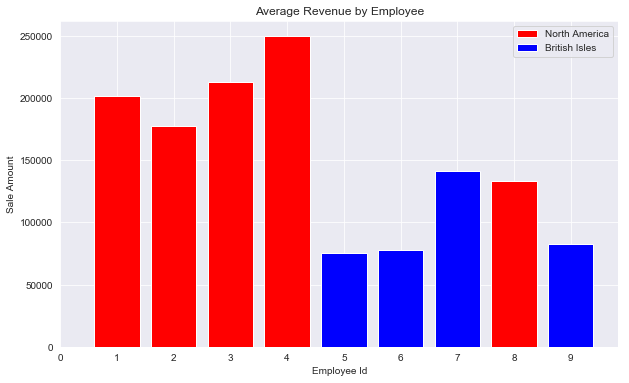

In [467]:
# let's visualize the revenue generated by each employee from each region
plt.figure(figsize=(10, 6))
X = rev_by_emp['EmployeeId']
y = rev_by_emp['Revenue']

mask1 = rev_by_emp.Region == 'North America'
mask2 = rev_by_emp.Region == 'British Isles'

plt.bar(X[mask1], y[mask1], color = 'red')
plt.bar(X[mask2], y[mask2], color = 'blue')

plt.xlabel('Employee Id')
plt.ylabel('Sale Amount')
plt.legend(('North America','British Isles'), loc='upper right')

plt.title('Average Revenue by Employee')
plt.xticks(np.arange(0, 10, step=1));

We can see that the top four earners are all from North America and the bottom three earners are all from the British Isles. But is this due to coincidence or does location have a significant effect on revenue generated? <br/> <br/>We need the sum of the orders (in $) as well as the employee ID and the region of that employee. We will make two dataframes, one for US and one for UK

In [468]:
US_employee_df = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             WHERE Region = 'North America'
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
US_employee_df.head()

,EmployeeId,Region,Revenue
0,4,North America,249536.3550
1,3,North America,212652.6125
2,1,North America,201763.0405
3,2,North America,177431.4755
4,8,North America,132962.2245


In [469]:
UK_employee_df = pd.read_sql_query('''SELECT EmployeeID , Region, 
                             SUM((UnitPrice*Quantity) - (UnitPrice*Discount)) as 'Revenue'
                             FROM [Order] 
                             INNER JOIN OrderDetail ON OrderDetail.OrderId = [Order].Id
                             INNER JOIN Employee ON Employee.Id = [Order].EmployeeId
                             WHERE Region = 'British Isles'
                             GROUP BY EmployeeID ORDER BY Revenue DESC
                             ;''', conn)
UK_employee_df.head()

,EmployeeId,Region,Revenue
0,7,British Isles,140868.0110
1,9,British Isles,82771.5430
2,6,British Isles,78006.7955
3,5,British Isles,75352.9100


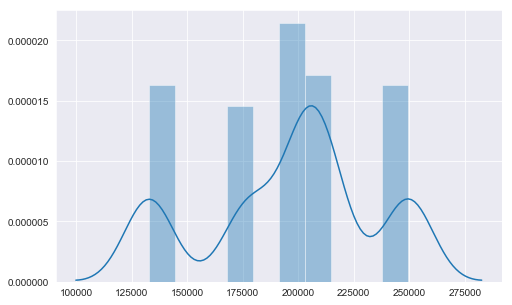

In [472]:
sns_histogram(np.random.choice(US_employee_df.Revenue, size = 100), bins = 10)

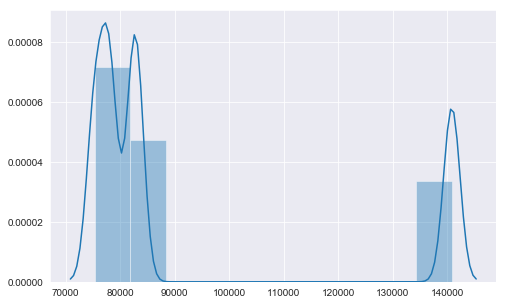

In [473]:
sns_histogram(np.random.choice(UK_employee_df.Revenue, size = 100), bins = 10)

### Assumptions

Checking normality using the **Shapiro-Wilk** Test:<br/>
- H0: distribution is normal
- H1: distribution is not normal

In [88]:
# Use the Shapiro-Wilk Test to check for normality of the distribution
print("For US employees: ", scs.shapiro(US_employee_df.Revenue))
print("For UK employees: ", scs.shapiro(UK_employee_df.Revenue))

For US employees:  (0.987162709236145, 0.9688442349433899)
For UK employees:  (0.7174993753433228, 0.018225325271487236)


- The p-value is greater than 0.05 for US employees, so we fail to reject the null hypothesis that the distribution is normal. 

- The p-value is smaller than 0.05 for UK employees, so we reject the null hypothesis that the distribution is normal. 
<br/>
Now let's use the Levene test to check the equality of variances: <br/>
- H0: variances are normal
- H1: variances are not normal

In [89]:
print(scs.levene(US_employee_df.Revenue, UK_employee_df.Revenue))

LeveneResult(statistic=0.4561537843544927, pvalue=0.5211053615904436)


The low p-value indicates that the variances between the two samples are unequal. Since the distribution is not normal and the variances are different, we should not use a student's t-test. Instead, we will use Welch's T-test which accounts for unequal variances.

## Welch's T-Test

In [474]:
# Ensuring randomness of samples
sample_UK=np.random.choice(UK_employee_df.Revenue, size=100)
sample_US=np.random.choice(US_employee_df.Revenue, size=100)

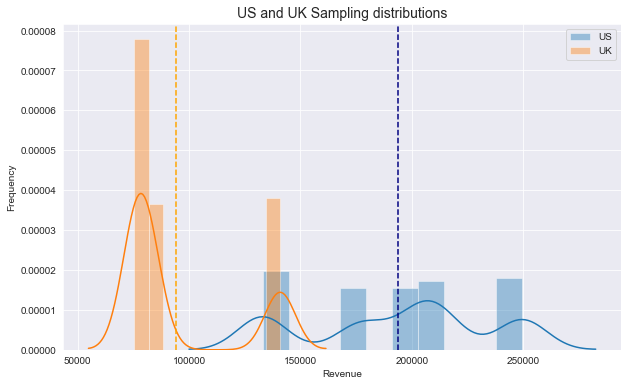

In [475]:
plt.figure(figsize=(10, 6))
plt.grid(True)
sns.distplot(sample_US, bins=10, label = 'US')
sns.distplot(sample_UK, bins=10, label = 'UK')

plt.axvline(x=sample_US.mean(), color='navy', linestyle = '--')
plt.axvline(x=sample_UK.mean(), color='orange', linestyle = '--')

plt.title('US and UK Sampling distributions', fontsize = 14)
plt.xlabel('Revenue')
plt.ylabel('Frequency')

plt.legend()
plt.show();

In [476]:
p = stats.ttest_ind(US_employee_df.Revenue, UK_employee_df.Revenue)[1]
print("p-value: ", p)
print('Reject Null Hypothesis') if p < 0.05 else print('Failed to reject Null Hypothesis')

p-value:  0.00598575124863274
Reject Null Hypothesis


The p-value is extremely low so we reject the null hypothesis that there is no difference between the revenue of US and UK employees. 

## Cohen's D Statistic for Effect Size

d=0.2 be considered a 'small' effect size

d=0.5 represents a 'medium' effect size

d=0.8 a 'large' effect size.

In [477]:
d = Cohen_d(US_employee_df.Revenue, UK_employee_df.Revenue)
print("Cohen's d: ", d)

Cohen's d:  2.6211608834769646


Our d-statistic is quite large, which suggests employee region has a large effect size on the amount of revenue brought in by the employee.

## Conclusions and Business Recommendations

- We concluded that there is a large, significant difference between the amount of total revenue brought in by US employees compared to UK employees. 
- This partly may be due to Northwind being more established in the US compared to the UK or there may be more competition in the specialty food trading industry in the UK.
- Would recommend investing in US employee infrastructure, opening more locations in North America. 

## Future Work for Question 2

- It may be beneficial to look into competing food trade companies in the UK compared to the US.
- Now there may be a Larger dataset to compare which may yield interesting results

# Question 3 
## *Do people who order more frequently than average also generate more sales?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> Customers who place orders more frequently spend the same amount as customers who order less frequently.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> Customers who place more orders spend more money than customers who place less orders. 
<br/>
<br/>
To answer this question, we need the total sales amount per customerID and the count of orders placed by each customerID.

### Exploring our data:

In [478]:
data3 = pd.read_sql_query('''SELECT o.CustomerID,
                             SUM((od.UnitPrice*od.Quantity) - 
                             (od.UnitPrice*od.Quantity*od.Discount)) as 'TotalAmount',
                             COUNT(o.Id) as 'CountOrders'
                             FROM 'Order' o 
                             JOIN 'OrderDetail' od ON o.ID = od.OrderId
                             GROUP BY o.CustomerId
                             ;''', conn)

In [479]:
data3.head() 

,CustomerId,TotalAmount,CountOrders
0,ALFKI,4273.0000,12
1,ANATR,1402.9500,10
2,ANTO,7023.9775,17
3,AROUT,13390.6500,30
4,BERGS,24927.5775,52


In [480]:
data3.info() # brief overview - no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 3 columns):
CustomerId     89 non-null object
TotalAmount    89 non-null float64
CountOrders    89 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ KB


In [481]:
# Get the median of the order frequency to create the samples
med_CO = data3['CountOrders'].median()
med_CO

20.0

In [482]:
# Create 2 sample groups, high frequency and low frequency
high_freq = data3.loc[data3['CountOrders'] > med_CO]
low_freq = data3.loc[data3['CountOrders']<= med_CO]

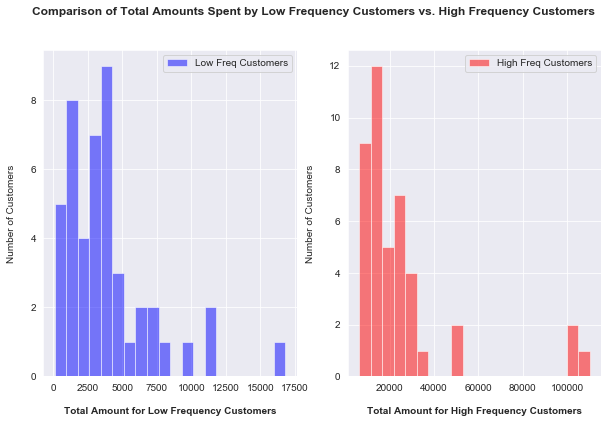

In [483]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

ax1.hist(low_freq['TotalAmount'], bins = 20, color = 'b', alpha= 0.5, label = 'Low Freq Customers') 
ax1.set_xlabel('\nTotal Amount for Low Frequency Customers', fontweight='bold')
ax1.set_ylabel('Number of Customers\n')
ax1.legend()

ax2.hist(high_freq['TotalAmount'], bins = 20, color = 'r', alpha= 0.5, label = 'High Freq Customers') 
ax2.set_xlabel('\nTotal Amount for High Frequency Customers', fontweight='bold')
ax2.set_ylabel('Number of Customers\n')
ax2.legend()

fig.suptitle('Comparison of Total Amounts Spent by Low Frequency Customers vs. High Frequency Customers', fontweight='bold')
plt.show()

Both distributions look skewed to the left, therefore not normally distributed. Just for sanity sake, we'll double check using the Shapiro-Wilk test for normality.

### Assumptions

Checking normality using the **Shapiro-Wilk** Test:<br/>
- H0: distribution is normal
- H1: distribution is not normal

In [103]:
print(scs.shapiro(high_freq['TotalAmount']))
print(scs.shapiro(low_freq['TotalAmount']))

(0.6320275068283081, 3.807205661843227e-09)
(0.8364682793617249, 1.392168542224681e-05)


Both p-values are extremely small, which confirms that the distributions are not normal. Now we will perform the Levene test to check the homogeneity of variances. <br/> 
- H0: variances are normal
- H1: variances are not normal

In [484]:
print(scs.levene(high_freq['TotalAmount'], low_freq['TotalAmount']))

LeveneResult(statistic=11.818379956321802, pvalue=0.0009019045930232378)


The low p-value indicates that the variances between the two samples are unequal. Since the distribution is not normal and the variances are different, we should not use a t-test. 
<br/>
<br/>
Instead, we will use a non-parametric method: the Monte Carlo simulation.

## Monte Carlo Simulation with Effect Size

Monte Carlo simulation substitutes a range of values for any factor with inherent uncertainty and then calculates results over and over, each time with a different random set of values.

In [485]:
len(high_freq), len(low_freq) # Check the length of our high frequency and low frequency samples

(43, 46)

In [486]:
mean_diff = np.mean(high_freq['TotalAmount']) - np.mean(low_freq['TotalAmount'])
mean_diff

21086.921466632968

Starting 10 samples


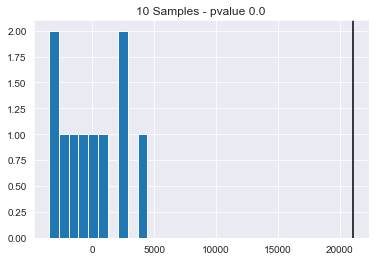

Took 0.31
Starting 100 samples


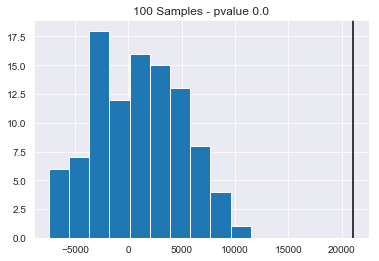

Took 0.66
Starting 500 samples


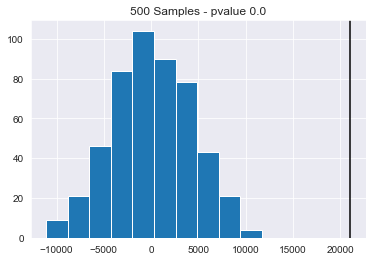

Took 2.11
Starting 1000 samples


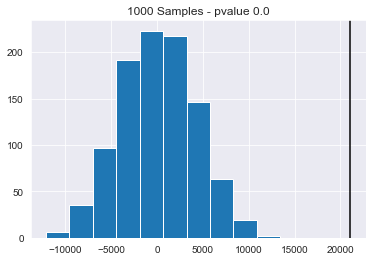

Took 3.41
Starting 10000 samples


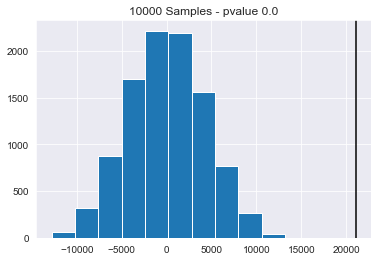

Took 31.85


In [487]:
import time
for x in [10, 100, 500, 1000, 10000]:
    
    """In this function, we will write a for loop to portray different numbers of iterations
       ranging from 10-100000. We will also compare the time it takes for the function to run at 
       different iteration levels. The for loop will compare the mean of the sample differences 
       to the mean of the population differences to determine if the 'TotalAmount' is significantly
       effected by the frequency of orders. In addition to p-value, we are also calculating effect 
       size using Cohen's d. """
    
    t0 = time.time()
    print(f'Starting {x} samples')
    mean_diff = np.mean(high_freq['TotalAmount'])-np.mean(low_freq['TotalAmount'])

    sample_diffs = []

    counter = 0

    for i in range(x):
        sample_high = data3.sample(replace=False, n=len(high_freq['TotalAmount']))
        sample_low = data3.drop(sample_high.index, axis=0)
        sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
        sample_diffs.append(sample_diff)
        
        if sample_diff > mean_diff:
            counter+= 1
                
    plt.hist(sample_diffs)
    plt.axvline(mean_diff, color = 'k')
    plt.title(f'{x} Samples - pvalue {counter/x}');
    plt.show()
    t1 = time.time()
    print(f'Took {np.round(t1-t0, 2)}')

We can see that the more iterations the monte carlo simulation performs, the more normal the distribution becomes as it follows the Central Limit Theorem. We tested the simulation with 10, 100, 500, 1000, and 10000 iterations and we obtained a p-value of 0.0 for each one. Therefore, we reject the null hypothesis that customers who place orders more frequently spend the same amount as customers who order less frequently.

## Cohen's D Statistic for Effect Size

d=0.2 be considered a 'small' effect size

d=0.5 represents a 'medium' effect size

d=0.8 a 'large' effect size.

In [488]:
d = Cohen_d(sample_high.TotalAmount, sample_low.TotalAmount)
print("Cohen's d: ", d)

Cohen's d:  0.1559010410059512


The effect of order frequency on the total amount spent by the customer is small (effect size < 0.2). 
<br/><br/>
When thinking about which customers are considered "high frequency" or "low frequency" we did not take into account when customers placed their first orders. People who have been customers for a longer period of time would theoretically have more orders than people who became customers more recently. To reduce this bias, we will determine when customers placed their first order and sample from that month onwards. 

## Experiment 2
<br/>
To determine when each customer placed their first order, we need to create a new dataframe just like the previous sql query, but including the order dates. 

In [489]:
data4 = pd.read_sql_query('''SELECT o.Id, o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            GROUP BY o.Id
                            ;''', conn)
data4.head()

,Id,CustomerId,OrderDate,TotalAmount
0,10248,VINET,2012-07-04,440.00
1,10249,TOMSP,2012-07-05,1863.40
2,10250,HANAR,2012-07-08,1552.60
3,10251,VICTE,2012-07-08,654.06
4,10252,SUPRD,2012-07-09,3597.90


In [490]:
data4.info()  # We can see that 'OrderDate' is an object type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
Id             830 non-null int64
CustomerId     830 non-null object
OrderDate      830 non-null object
TotalAmount    830 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.0+ KB


In [491]:
# let's change 'OrderDate' from an object to datetime

data4['OrderDate'] = pd.to_datetime(data4['OrderDate'])
data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 4 columns):
Id             830 non-null int64
CustomerId     830 non-null object
OrderDate      830 non-null datetime64[ns]
TotalAmount    830 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 26.0+ KB


In [492]:
#select the customer IDs from the high and low frequency from the second dataset
high_freq = data4.loc[data4['CustomerId'].isin(high_freq['CustomerId'])]
low_freq = data4.loc[data4['CustomerId'].isin(low_freq['CustomerId'])]

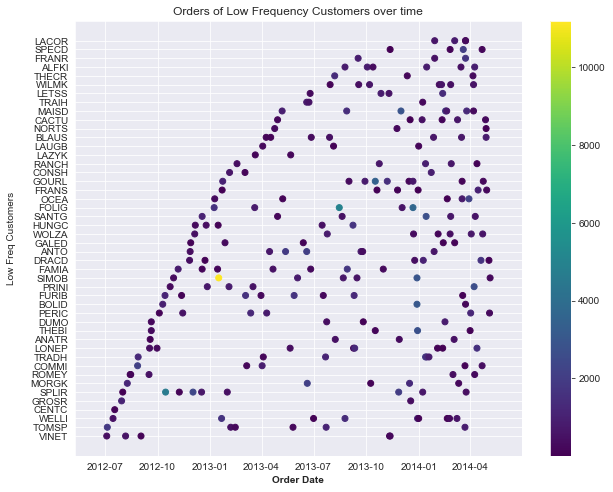

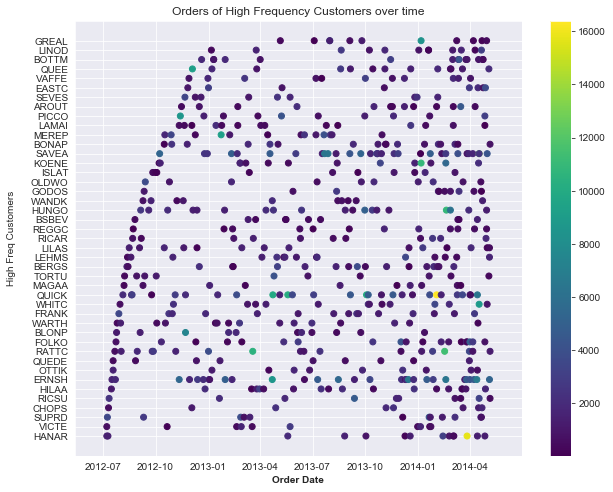

In [493]:
plt.figure(figsize=(10, 8))
sc = plt.scatter(low_freq['OrderDate'], low_freq['CustomerId'], marker='o', c=low_freq['TotalAmount'], cmap='viridis', vmin=low_freq['TotalAmount'].min(), vmax=low_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('Low Freq Customers\n')
plt.title('Orders of Low Frequency Customers over time')
plt.colorbar(sc)
plt.show()

plt.figure(figsize=(10, 8))
sc2 = plt.scatter(high_freq['OrderDate'], high_freq['CustomerId'], marker='o', c=high_freq['TotalAmount'], cmap='viridis', vmin=high_freq['TotalAmount'].min(), vmax=high_freq['TotalAmount'].max())
plt.xlabel('Order Date', fontweight='bold')
plt.ylabel('High Freq Customers\n')
plt.title('Orders of High Frequency Customers over time')
plt.colorbar(sc2)
plt.show()

We can see that by 2013-07 the majority of the total customers placed at least one order. 

In [494]:
data5 = pd.read_sql_query('''SELECT o.CustomerId, o.OrderDate, 
                            SUM((od.UnitPrice * od.Quantity) - (od.UnitPrice * od.Quantity * od.Discount )) as 'TotalAmount',
                            COUNT(o.Id) as 'CountOrders'
                            FROM 'Order' o
                            JOIN 'OrderDetail' od ON o.Id = od.OrderId
                            WHERE o.OrderDate > '2013-07-01'
                            GROUP BY o.CustomerId
                            ;''', conn)
data5.head()

,CustomerId,OrderDate,TotalAmount,CountOrders
0,ALFKI,2013-08-25,4273.0000,12
1,ANATR,2013-08-08,1314.1500,8
2,ANTO,2013-09-22,1848.8650,7
3,AROUT,2013-10-16,9461.0500,18
4,BERGS,2013-08-11,14702.8425,29


In [495]:
# data5.CountOrders.value_counts() # We can see that all customers ordered more than once

In [496]:
data5['CountOrders'].median()

11.0

In [497]:
#create 2 sample groups 
#sample groups are divided by the median order frequency (our independent variable)
#This will allow to check if the TotalAmount means between groups are significantly different
high_freq2 = data5.loc[data5['CountOrders'] > data5['CountOrders'].median()]
low_freq2 = data5.loc[data5['CountOrders'] <= data5['CountOrders'].median()]

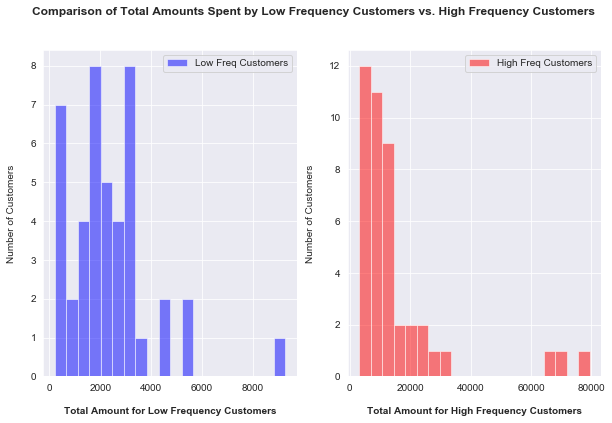

In [498]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,6))

ax1.hist(low_freq2['TotalAmount'], bins = 20, color = 'b', alpha= 0.5, label = 'Low Freq Customers') 
ax1.set_xlabel('\nTotal Amount for Low Frequency Customers', fontweight='bold')
ax1.set_ylabel('Number of Customers\n')
ax1.legend()

ax2.hist(high_freq2['TotalAmount'], bins = 20, color = 'r', alpha= 0.5, label = 'High Freq Customers') 
ax2.set_xlabel('\nTotal Amount for High Frequency Customers', fontweight='bold')
ax2.set_ylabel('Number of Customers\n')
ax2.legend()

fig.suptitle('Comparison of Total Amounts Spent by Low Frequency Customers vs. High Frequency Customers', fontweight='bold')
plt.show()

### Assumptions

Shapiro-Wilk Test for normality
- H0: distribution is normal
- H1: distribution is not normal

In [499]:
scs.shapiro(high_freq2['TotalAmount']), scs.shapiro(low_freq2['TotalAmount'])

((0.6363668441772461, 4.417351373575684e-09),
 (0.8657699823379517, 0.00011296177399344742))

The p-values are extremely low so we can reject the null hypothesis that the distribution is normal. 
<br/> <br/>
The Levene Test to assess the equality of variances <br/>
- H0: the variances are equal
- H1: the variances are not equal

In [500]:
print(scs.levene(high_freq2['TotalAmount'], low_freq2['TotalAmount']))

LeveneResult(statistic=11.843897435257695, pvalue=0.0008994694081663188)


The p-value is small so we can reject the null that the variances are equal.
<br/>
<br/>
Since the distribution is not normal and the variances are not equal, we will use the non-parametric method Monte Carlo Simulation again.

## Monte Carlo Simulation for Experiment 2

In [501]:
#get the mean difference 
mean_diff = high_freq2['TotalAmount'].mean() - low_freq2['TotalAmount'].mean()
mean_diff

13273.996675475688

In [502]:
sample_diffs = []
counter = 0

# We will use 10000 iterations to be sure the estimate of the means is accurate
for i in range(10000):
    sample_high = data5.sample(replace=False, n=len(high_freq2['TotalAmount']))
    sample_low = data5.drop(sample_high.index, axis=0) 
    sample_diff = sample_high['TotalAmount'].mean() - sample_low['TotalAmount'].mean()
    sample_diffs.append(sample_diff)
    if sample_diff > mean_diff:
        counter += 1

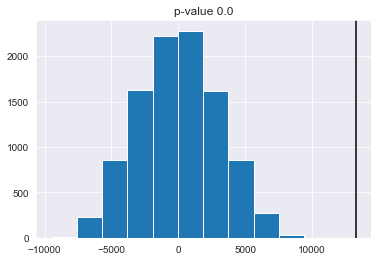

In [503]:
plt.hist(sample_diffs)
plt.axvline(mean_diff, color = 'k')
plt.title(f'p-value {np.round(counter/10000, 3)}');
plt.show()

## Conclusions and Business Recommendations

- With and without taking into account the date of first order, the p-value is low so we can reject the null hypothesis that there is no difference in the total amount spent by customers who place orders more frequently compared to customers who order less frequently. 
- We could create a 'membership' program that gives discounts or benefits to frequent shoppers
- Invest in aggressive marketing campaigns so people will purchase more frequently

## Future Work for Question 3

- Since all the customers have ordered from Northwind more than once, it would be interesting to investigate the rate of new customer growth over time. It may be beneficial in developing new marketing strategies geared towards broadening the customer base.

# Question 4 
## *Is there a significant difference in the freight costs by region?*

 - H<sub>0</sub>: $\mu$<sub>1</sub> = $\mu$<sub>2</sub> There is no significant difference in the freight costs by region.
 - H<sub>1</sub>: $\mu$<sub>1</sub> > or < $\mu$<sub>2</sub> There are significant differences in the freight costs by region.
<br/>
<br/>
To answer this question, we need the sum of the freight costs or each region

### Exploring our data:

In [504]:
Order_df.head()

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [505]:
print(Order_df['ShipRegion'].value_counts())

# We can see that there are 9 unique shipping regions. The region with the most orders is Western Europe
# with 276 orders and the region with the least orders is Eastern Europe with only 7 orders

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     28
Eastern Europe       7
Name: ShipRegion, dtype: int64


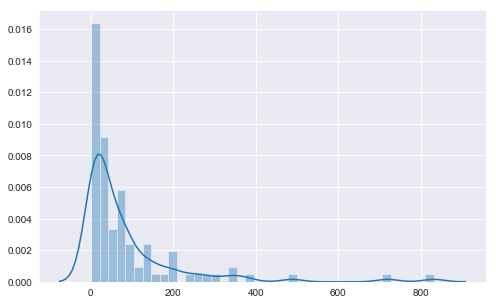

In [506]:
sns_histogram(np.random.choice(Order_df.Freight, size=100), bins=40)
# The distribution is skewed to the left and not normal. 

In [519]:
# Let's first get an understanding of the total freight costs in each region
data6 = pd.read_sql_query('''SELECT SUM(Freight) as 'SumFreight', ShipRegion
                             FROM [Order]
                             GROUP BY ShipRegion
                             ORDER BY SumFreight DESC
                             ;''', conn)
data6

,SumFreight,ShipRegion
0,25561.29,Western Europe
1,15969.38,North America
2,8213.95,South America
3,5709.51,British Isles
4,4633.79,Northern Europe
5,2369.86,Southern Europe
6,1186.39,Scandinavia
7,1122.78,Central America
8,175.74,Eastern Europe


We can see that Western Europe and North America have the highest shipping costs by far and Eastern Europe has the lowest. We want to explore if these differences in freight cost are by chance or if region is the driving factor influencing freight cost. <br/><br/>
Now let's get the order data from the database for analysis

In [520]:
#SQL query to retrieve all information from 'Order' table
data7 = pd.read_sql("SELECT * from [order]", conn)
print(data7.ShipRegion.value_counts())
data7.head()

Western Europe     276
North America      152
South America      145
British Isles       75
Southern Europe     64
Northern Europe     55
Scandinavia         28
Central America     28
Eastern Europe       7
Name: ShipRegion, dtype: int64


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


### Assumptions

Checking normality using the **Shapiro-Wilk** Test:<br/>
- H0: distribution is normal
- H1: distribution is not normal

In [521]:
scs.shapiro(data7.Freight)

(0.612465500831604, 1.731211766974666e-39)

The p-value is extremely small, so we reject the null hypothesis that the distribution is normal. What if we took the distribution of the sample means of a large number of random samples? Would the distribution be more normal assuming it follows the central limit theorem?

In [522]:
sample_means = []

for i in range(50):
    sample = np.random.choice(data7.Freight, size =50).mean()
    sample_means.append(sample)

In [523]:
sd = np.std(sample_means, ddof=1) 
# using standard deviation of the sample means with 1 degree of freedom since distribution is not normal - 
# provides an unbiased estimator of the variance of the infinite population

In [526]:
sd, np.std(sample_means) 

(14.402529066530118, 14.257776356851723)

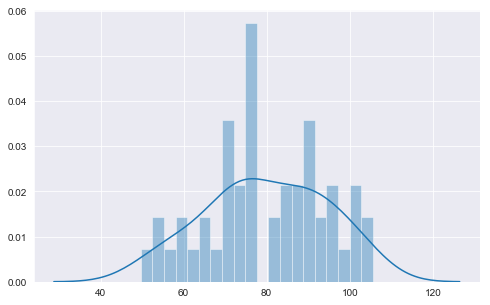

In [525]:
sns_histogram(sample_means)

In [527]:
# lets check the normality of the sample means distribution to see if it is normal compared to 
# the distribution of the SumFreight costs. 

scs.shapiro(sample_means)

(0.9767025709152222, 0.42275893688201904)

The p-value is greater than 0.05, so we **fail to reject** the null hypothesis that the distribution is normal. But we must remember that this is in regards to the **distribution of sample means**.

The Levene Test to assess the equality of variances: <br/>
- H0: the variances are equal
- H1: the variances are not equal

In [528]:
# random samples to maintain independence and random assumptions
samp1 = np.random.choice(data7.Freight, size=100)
samp2 = np.random.choice(data7.Freight, size=100)
scs.levene(samp1, samp2) 

LeveneResult(statistic=2.6577605319772517, pvalue=0.10463545370161133)

The p-value is high so we fail to reject the null hypothesis that the variances are equal between the two samples.

Since we failed to reject the null that the distribution of Freight costs is normal and the null that the variances are equal, we can use pairwise t-tests. We will use the Tukey multicomparison test.

## Tukey Multiwise Comparison

In [529]:
mod = MultiComparison(data7.Freight, data7.ShipRegion)

In [531]:
print(mod.tukeyhsd())

        Multiple Comparison of Means - Tukey HSD,FWER=0.05        
     group1          group2     meandiff   lower    upper   reject
------------------------------------------------------------------
 British Isles  Central America -36.0275 -115.2593 43.2043  False 
 British Isles   Eastern Europe -51.0211 -192.4108 90.3686  False 
 British Isles   North America  28.9349   -21.5488 79.4186  False 
 British Isles  Northern Europe  8.1239   -55.3872 71.6351  False 
 British Isles    Scandinavia   -33.7557 -112.9875 45.4761  False 
 British Isles   South America  -19.4789  -70.3636 31.4058  False 
 British Isles  Southern Europe -39.0977  -99.9781 21.7826  False 
 British Isles   Western Europe 16.4866   -30.0998 63.0729  False 
Central America  Eastern Europe -14.9936 -166.1743 136.1872 False 
Central America  North America  64.9624   -8.6118  138.5367 False 
Central America Northern Europe 44.1514   -38.9042 127.2071 False 
Central America   Scandinavia    2.2718   -93.3433 97.8869  Fa

From the Tukey multi comparison test, we can see that there is a significant difference between the means of the following:
 - North America vs. South America
 - North America vs. Southern Europe
 - Southern Europe vs. Western Europe

## Cohen's D Statistic for Effect Size

d=0.2 be considered a 'small' effect size

d=0.5 represents a 'medium' effect size

d=0.8 a 'large' effect size.

In [532]:
sa = data7.Freight[data7.ShipRegion=='South America']
na = data7.Freight[data7.ShipRegion=='North America']
we = data7.Freight[data7.ShipRegion=='Western Europe']
se = data7.Freight[data7.ShipRegion=='Southern Europe']

In [533]:
d_na_sa = Cohen_d(na, sa)
d_na_se = Cohen_d(na, se)
d_se_we = Cohen_d(se, we)

print("Cohen's d for North America and South America is: {}".format(d_na_sa))
print("Cohen's d for North America and Southern Europe is: {}".format(d_na_se))
print("Cohen's d for Southern Europe and Western Europe is: {}".format(d_se_we))

Cohen's d for North America and South America is: 0.3889410582308617
Cohen's d for North America and Southern Europe is: 0.5262640910150637
Cohen's d for Southern Europe and Western Europe is: 0.4630891921197653


The difference in freight costs between North America and South America and between Southern Europe and Western Europe are small and the difference in freight costs between North America and Southern Europe is medium.

We have found a significant difference in the freighting costs in a few diffrent regions, but this may also be influenced by the shipping companies used to freight the orders. 

## Part 2:
<br/>
Next, we will explore the different shipping companies and determine if there is a significant difference in the freighting costs. For this new question, we will need to develop a new set of hypotheses:
<br/>
- H0: There is no difference in the freighting costs between companies<br/>
- H1: There is a difference in freighting costs between companies

In [534]:
# We will need the shipper dataframe to answer this hypothesis
Shipper_df

,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


In [535]:
data8 = pd.read_sql_query('''SELECT s.CompanyName, o.Freight, o.ShipRegion
                             FROM 'Shipper' s
                             JOIN 'Order' o ON o.ShipVia = s.Id
                             ;''', conn)

print(data8.CompanyName.value_counts()) #United Package frieghts the most orders, Speedy Express the least
data8.head()

United Package      326
Federal Shipping    255
Speedy Express      249
Name: CompanyName, dtype: int64


,CompanyName,Freight,ShipRegion
0,Federal Shipping,32.38,Western Europe
1,Speedy Express,11.61,Western Europe
2,United Package,65.83,South America
3,Speedy Express,41.34,Western Europe
4,United Package,51.30,Western Europe


In [536]:
# separate the shipping companies into their own dfs
up_df = data8.loc[data8['CompanyName']== 'United Package']
fed_df = data8.loc[data8['CompanyName']== 'Federal Shipping']
SpEx_df = data8.loc[data8['CompanyName']== 'Speedy Express']

In [537]:
data8.groupby('CompanyName').describe() #some basic stats

Freight                                                     \
                   count       mean         std   min    25%     50%    75%   
CompanyName                                                                   
Federal Shipping   255.0  80.441216  119.362844  0.40  12.86  36.710  99.49   
Speedy Express     249.0  65.001325   75.393587  0.12  12.75  40.420  89.90   
United Package     326.0  86.640644  138.219262  0.02  14.04  44.135  91.43   

                           
                      max  
CompanyName                
Federal Shipping  1007.64  
Speedy Express     458.78  
United Package     890.78

We can see that Speedy Express has the lowest mean freight cost and United Package has the highest.

In [538]:
print('United Package: ', scs.shapiro(up_df['Freight']))
print('Federal Shipping: ', scs.shapiro(fed_df['Freight']))
print('Speedy Express: ', scs.shapiro(SpEx_df['Freight']))

United Package:  (0.5826082229614258, 2.954606683318374e-27)
Federal Shipping:  (0.6275749802589417, 3.371958171463351e-23)
Speedy Express:  (0.7692915201187134, 2.024363869389547e-18)


We can reject the null hypotheses that the distribution is normal for all three shipping companies.

In [539]:
print(scs.levene(up_df['Freight'], fed_df['Freight']))
print(scs.levene(up_df['Freight'], SpEx_df['Freight']))
print(scs.levene(fed_df['Freight'], SpEx_df['Freight']))

LeveneResult(statistic=0.22221820078481805, pvalue=0.637532504906012)
LeveneResult(statistic=5.797701313971681, pvalue=0.01636207950725744)
LeveneResult(statistic=4.237218518886453, pvalue=0.04006243542614962)


We fail to reject the null hypothesis that the variances are equal between United Package and Federal Shipping. This means the variances may be equal. When testing the variances between United Package and Speedy express and between Federal Shipping and Speedy Express, we reject the null hypothesis. This means the variances are not equal. Since variance is unequal, we will try the Tukey method to determine which means are significantly different.

In [540]:
mod = MultiComparison(data8.Freight, data8.CompanyName)

In [541]:
print(mod.tukeyhsd())

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper  reject
----------------------------------------------------------------
Federal Shipping Speedy Express -15.4399 -39.825   8.9452 False 
Federal Shipping United Package  6.1994  -16.6823 29.0811 False 
 Speedy Express  United Package 21.6393  -1.3965  44.6752 False 
----------------------------------------------------------------


The Tukey test results show that none of the total freight costs between the three shipping companies are significantly different. The Tukey test assumes a normal distribution so this may not be the most accurate method for this data. Let's further explore with Welch's t-test.

In [545]:
# t-test assumes equal variance - Normal t-test
p = stats.ttest_ind(up_df.Freight, fed_df.Freight)[1]
p

0.5694520818370383

In [546]:
# Equal variance is 'False' since variances were found to be unequal using Levene Test
# so performs Welch's t-test
p = stats.ttest_ind(up_df.Freight, SpEx_df.Freight, equal_var = False)[1]
p

0.016834217839542445

In [547]:
# Equal variance is 'False' since variances were found to be unequal using Levene Test
# so performs Welch's t-test
p = stats.ttest_ind(SpEx_df.Freight, fed_df.Freight, equal_var = False)[1]
p

0.08249922098927637

From the t-tests, there is a significant difference between United Package and Speedy Express. 

In [551]:
d = Cohen_d(up_df.Freight, SpEx_df.Freight)
print("Cohen's d: ", d)  # small effect size

Cohen's d:  0.1876863702137116


## Conclusions and Business Recommendations

- We determined that there are statistically significant differences in the freight costs between North America and South America, North America and Southern Europe, and Southern Europe and Western Europe.
- The difference in freight costs between North America and South America and between Southern Europe and Western Europe are small and the difference in freight costs between North America and Southern Europe is medium.
- May be beneficial to open shipping warehouses in North America and Western Europe in the future in order to decrease freight distance and cost for those high revenue regions. 
- Speedy Express has a significantly lower freight cost than United Package but there is no significant difference between United Package and Federal Shipping or Speedy Express and Federal Shipping
- We may increase profit margins by freighting more of our products using Speedy Express

## Future Work for Question 4

- Investigate if the shipping company significantly affects the total revenue.
- Determine which freight companies have the quickest delivery times on average